# Cell-type count classifier baseline (CTCC)

Applied to the COMBAT dataset.

In [1]:
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from tqdm import tqdm, trange

sns.set_style("darkgrid")

import sys
sys.path.append("src")  # hacky way to get access to the util.save_perf
from util import save_perf

In [2]:
adata = ad.read_h5ad("data/COMBAT/COMBAT-CITESeq-DATA-top2000.h5ad")

In [3]:
adata

AnnData object with n_obs × n_vars = 836148 × 2000
    obs: 'Annotation_cluster_id', 'Annotation_cluster_name', 'Annotation_minor_subset', 'Annotation_major_subset', 'Annotation_cell_type', 'GEX_region', 'QC_ngenes', 'QC_total_UMI', 'QC_pct_mitochondrial', 'QC_scrub_doublet_scores', 'TCR_chain_composition', 'TCR_clone_ID', 'TCR_clone_count', 'TCR_clone_proportion', 'TCR_contains_unproductive', 'TCR_doublet', 'TCR_chain_TRA', 'TCR_v_gene_TRA', 'TCR_d_gene_TRA', 'TCR_j_gene_TRA', 'TCR_c_gene_TRA', 'TCR_productive_TRA', 'TCR_cdr3_TRA', 'TCR_umis_TRA', 'TCR_chain_TRA2', 'TCR_v_gene_TRA2', 'TCR_d_gene_TRA2', 'TCR_j_gene_TRA2', 'TCR_c_gene_TRA2', 'TCR_productive_TRA2', 'TCR_cdr3_TRA2', 'TCR_umis_TRA2', 'TCR_chain_TRB', 'TCR_v_gene_TRB', 'TCR_d_gene_TRB', 'TCR_j_gene_TRB', 'TCR_c_gene_TRB', 'TCR_productive_TRB', 'TCR_chain_TRB2', 'TCR_v_gene_TRB2', 'TCR_d_gene_TRB2', 'TCR_j_gene_TRB2', 'TCR_c_gene_TRB2', 'TCR_productive_TRB2', 'TCR_cdr3_TRB2', 'TCR_umis_TRB2', 'BCR_umis_HC', 'BCR_contig_qc_HC

In [4]:
SAMPLE_COL = "Donor ID"
CELLTYPE_COL = "Annotation_minor_subset"
LABEL = "SARSCoV2PCR"

In [5]:
# count the number of cells per celltype per sample

DONORS = adata.obs[SAMPLE_COL].unique()
CELLTYPES = adata.obs[CELLTYPE_COL].unique()

counts = np.zeros((len(DONORS), len(CELLTYPES)), dtype=int)
for i, donor in enumerate(tqdm(DONORS)):
    for j, celltype in enumerate(CELLTYPES):
        counts[i, j] = adata[(adata.obs[SAMPLE_COL] == donor) & (adata.obs[CELLTYPE_COL] == celltype)].shape[0]

cdata_obs = adata.obs.groupby(SAMPLE_COL, observed=True).first().reset_index()
cdata_obs = cdata_obs.set_index(SAMPLE_COL)
cdata_obs[SAMPLE_COL] = cdata_obs.index
    
cdata = ad.AnnData(
    X=counts,
    obs=cdata_obs,
    var=pd.DataFrame(index=CELLTYPES, data={CELLTYPE_COL: CELLTYPES}),
)

100%|██████████| 140/140 [00:39<00:00,  3.55it/s]


In [6]:
def processing(adata, cpm: bool = True, log1p: bool = False, standardize: bool = True):
    """
    Preprocess the data for further analysis.
    
    Parameters:
    - adata: AnnData object containing the data.
    - cpm: If True, normalize counts per million.
    - log1p: If True, apply log1p transformation.
    - standardize: If True, standardize features.
    
    Returns:
    - Processed data as a tuple (X, Y).
    """
    X = adata.X
    Y = adata.obs[LABEL].values

    # counts per 10k
    if cpm:
        X = X / X.sum(axis=1)[:, None] * 1e4

    # log1p
    if log1p:
        X = np.log1p(X)

    # standardize features
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)

    return X, Y

In [7]:
X, Y = processing(cdata, cpm=True, log1p=False, standardize=True)

In [8]:
# Split by class
X_ct = X[Y == 0]
X_ad = X[Y == 1]
Y_ct = Y[Y == 0]
Y_ad = Y[Y == 1]

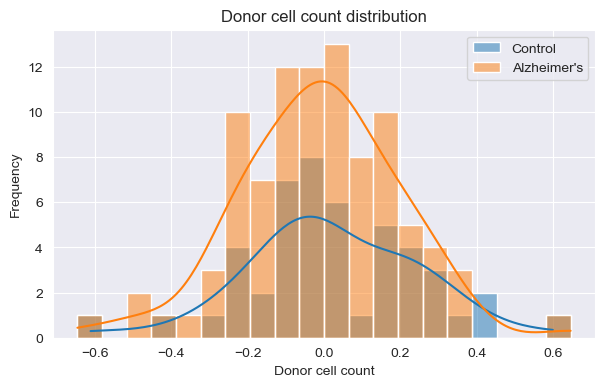

In [9]:
bins = np.histogram_bin_edges(X.mean(axis=1), bins=20)

fig, ax = plt.subplots(figsize=(7, 4))
sns.histplot(X_ct.mean(axis=1), bins=bins, kde=True, label="Control", ax=ax)
sns.histplot(X_ad.mean(axis=1), bins=bins, kde=True, label="Alzheimer's", ax=ax)
plt.title("Donor cell count distribution")
plt.xlabel("Donor cell count")
plt.ylabel("Frequency")
plt.legend()
plt.show()

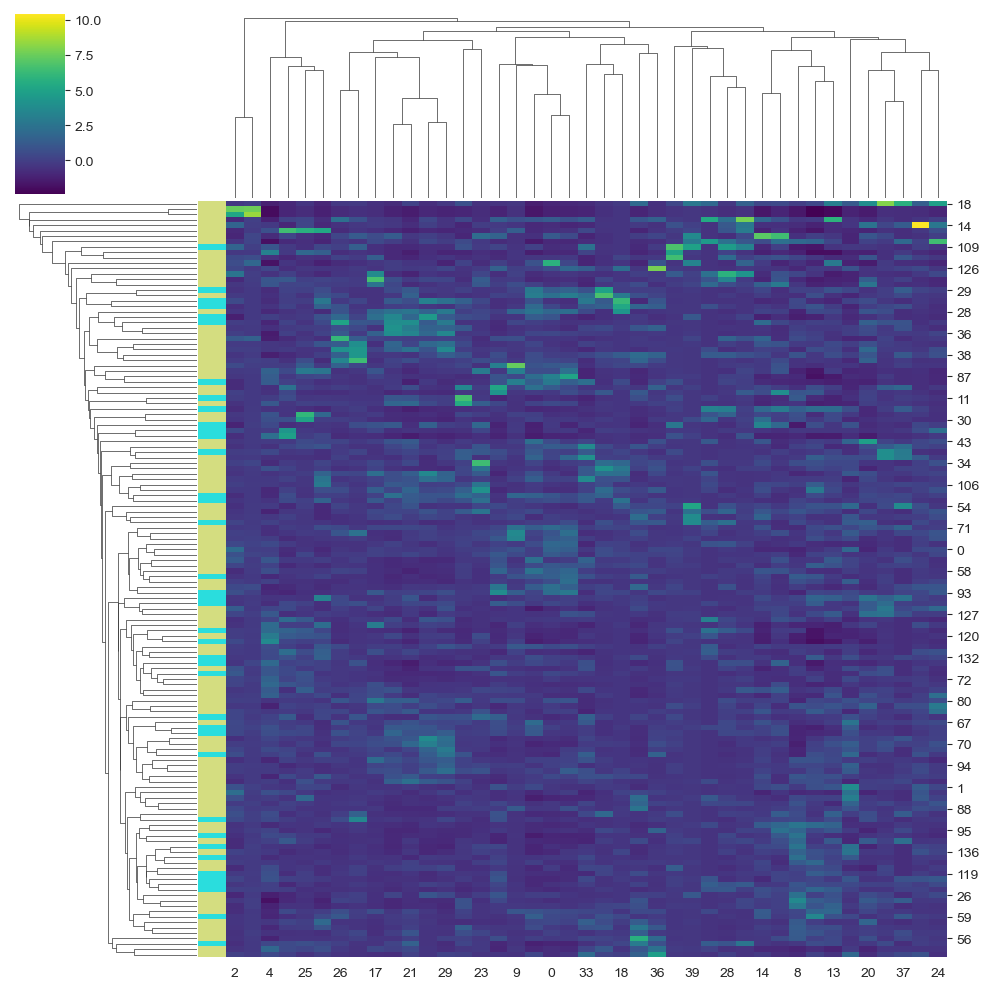

In [10]:
colors = sns.color_palette("rainbow", 2)
color_vals = adata.obs[LABEL].values
row_colors = pd.Series(color_vals).map({0: colors[0], 1: colors[1]}).values
sns.clustermap(X, cmap="viridis", figsize=(10, 10), row_colors=row_colors)
plt.show()

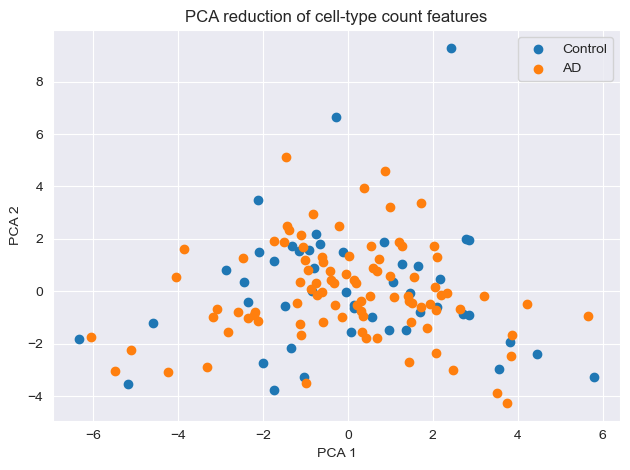

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=10)
X_pca = pca.fit_transform(X)

plt.scatter(X_pca[Y == 0, 0], X_pca[Y == 0, 1], label="Control")
plt.scatter(X_pca[Y == 1, 0], X_pca[Y == 1, 1], label="AD")
plt.title("PCA reduction of cell-type count features")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.legend()
plt.tight_layout()
plt.show()

c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\timo\Repositories\scAGG\.pixi\envs\default\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


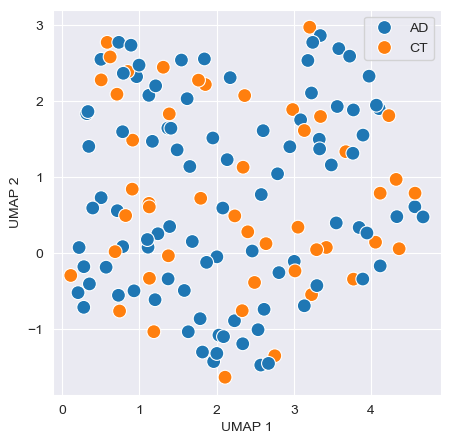

In [12]:
from umap import UMAP

umap = UMAP(n_components=2, n_neighbors=15, min_dist=0.1, metric="euclidean", random_state=42)
X_umap = umap.fit_transform(X)

import matplotlib.pyplot as plt
import seaborn as sns

label = ["AD" if y > 0.5 else "CT" for y in Y]

plt.figure(figsize=(5, 5))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=label, s=100)
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()

In [13]:
N_RUNS = 100
N_FOLDS = 5
SPLIT_SEED = None
# SPLIT_SEED = 42

from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression, Lasso, Ridge
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

feat_imp = np.zeros((N_RUNS, len(CELLTYPES)))
y_pred = []

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    y_pred.append([])

    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        model = Lasso(alpha=0.005)
        model.fit(X_train, Y_train)
        
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        auc = roc_auc_score(Y_test, y_pred_test)
        
        test_auc.append(auc)

        y_pred_train = (y_pred_train > 0.5).astype(int)
        y_pred_test = (y_pred_test > 0.5).astype(int)
        
        y_pred[j].append(y_pred_test)
        
        acc_train = (y_pred_train == Y_train).mean()
        acc_test = (y_pred_test == Y_test).mean()
        
        acc = accuracy_score(Y_test, y_pred_test)
        prec = precision_score(Y_test, y_pred_test)
        rec = recall_score(Y_test, y_pred_test)
        f1 = f1_score(Y_test, y_pred_test)
        
        test_accs.append(acc)
        test_prec.append(prec)  
        test_rec.append(rec)
        test_f1.append(f1)

        if j == 0:
            train_donors = cdata.obs[SAMPLE_COL].values[train_index]
            test_donors = cdata.obs[SAMPLE_COL].values[test_index]
            save_perf(
                exp_name="COMBAT_top2000",
                model_name="CTCC",
                fold=i,
                accuracy=acc,
                precision=prec,
                recall=rec,
                f1=f1,
                roc_auc=auc,
                train_donors=train_donors,
                test_donors=test_donors,
                train_y=Y_train.flatten(),
                test_y=Y_test.flatten(),
                train_y_pred=y_pred_train.flatten(),
                test_y_pred=y_pred_test.flatten(),
                processing="cpm=True, log1p=False, standardize=True",
            )
            print(f"Fold {i+1}/{N_FOLDS} - Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

        feat_imp[j] = model.coef_
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)
    
print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

  4%|▍         | 4/100 [00:00<00:02, 35.23it/s]

Fold 1/5 - Acc: 0.5357, Prec: 0.6667, Rec: 0.6316, F1: 0.6486, AUC: 0.4503
Fold 2/5 - Acc: 0.6071, Prec: 0.6667, Rec: 0.8421, F1: 0.7442, AUC: 0.4152
Fold 3/5 - Acc: 0.5357, Prec: 0.6500, Rec: 0.6842, F1: 0.6667, AUC: 0.5029
Fold 4/5 - Acc: 0.6071, Prec: 0.6667, Rec: 0.7778, F1: 0.7179, AUC: 0.5333
Fold 5/5 - Acc: 0.5357, Prec: 0.6190, Rec: 0.7222, F1: 0.6667, AUC: 0.5000


100%|██████████| 100/100 [00:02<00:00, 40.11it/s]

Mean test  acc: 0.6086 +/- 0.0266
Mean test prec: 0.6815 +/- 0.0168
Mean test  rec: 0.7739 +/- 0.0341
Mean test   f1: 0.7221 +/- 0.0218
Mean test  auc: 0.5410 +/- 0.0368


In [14]:
# Quickly try it with a 2-layer neural network

import torch

class Net(torch.nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.act(x)
        return x
    
def train_model(X_train, Y_train, X_test, Y_test, n_epochs=100, lr=0.001):
    net = Net(X_train.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    MAX_PATIENCE = 20
    patience = 0
    best_loss = np.inf
    best_weights = None

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = net(X_train).squeeze()
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience = 0
            best_weights = net.state_dict()
        else:
            patience += 1
            if patience > MAX_PATIENCE:
                break

    net.load_state_dict(best_weights)
    
    return net

N_RUNS = 5

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        net = train_model(X_train, Y_train, X_test, Y_test)
        
        X_test = torch.tensor(X_test, dtype=torch.float32)
        Y_test = torch.tensor(Y_test, dtype=torch.float32)
        
        with torch.no_grad():
            output = net(X_test).squeeze().numpy()
        
        test_auc.append(roc_auc_score(Y_test, output))
        
        output = (output > 0.5).astype(int)
        
        test_accs.append(accuracy_score(Y_test, output))
        test_prec.append(precision_score(Y_test, output))
        test_rec.append(recall_score(Y_test, output))
        test_f1.append(f1_score(Y_test, output))
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)

print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:03<00:00,  1.52it/s]

Mean test  acc: 0.5729 +/- 0.0245
Mean test prec: 0.6593 +/- 0.0208
Mean test  rec: 0.7441 +/- 0.0185
Mean test   f1: 0.6969 +/- 0.0158
Mean test  auc: 0.4842 +/- 0.0447


In [15]:
# Quickly try it with a 2-layer neural network

import torch

class Net(torch.nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        self.fc1 = torch.nn.Linear(input_size, 128)
        self.fc2 = torch.nn.Linear(128, 1)
        self.act = torch.nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        x = self.act(x)
        return x
    
def train_model(X_train, Y_train, X_test, Y_test, n_epochs=100, lr=0.001):
    net = Net(X_train.shape[1])
    criterion = torch.nn.BCELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.float32)
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.float32)
    
    MAX_PATIENCE = 20
    patience = 0
    best_loss = np.inf
    best_weights = None

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        output = net(X_train).squeeze()
        loss = criterion(output, Y_train)
        loss.backward()
        optimizer.step()

        if loss.item() < best_loss:
            best_loss = loss.item()
            patience = 0
            best_weights = net.state_dict()
        else:
            patience += 1
            if patience > MAX_PATIENCE:
                break

    net.load_state_dict(best_weights)
    
    return net

N_RUNS = 5

mean_accs = np.zeros(N_RUNS)
mean_prec = np.zeros(N_RUNS)
mean_rec = np.zeros(N_RUNS)
mean_f1 = np.zeros(N_RUNS)
mean_auc = np.zeros(N_RUNS)

for j in trange(N_RUNS):

    if SPLIT_SEED is not None:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SPLIT_SEED)
    else:
        kf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True)

    test_accs = []
    test_prec = []
    test_rec = []
    test_f1 = []
    test_auc = []
    
    for i, (train_index, test_index) in enumerate(kf.split(X, Y)):
        
        X_train = X[train_index]
        Y_train = Y[train_index]
        
        X_test = X[test_index]
        Y_test = Y[test_index]
        
        net = train_model(X_train, Y_train, X_test, Y_test)
        
        X_test = torch.tensor(X_test, dtype=torch.float32)
        Y_test = torch.tensor(Y_test, dtype=torch.float32)
        
        with torch.no_grad():
            output = net(X_test).squeeze().numpy()
        
        test_auc.append(roc_auc_score(Y_test, output))
        
        output = (output > 0.5).astype(int)
        
        test_accs.append(accuracy_score(Y_test, output))
        test_prec.append(precision_score(Y_test, output))
        test_rec.append(recall_score(Y_test, output))
        test_f1.append(f1_score(Y_test, output))
    
    mean_accs[j] = np.mean(test_accs)
    mean_prec[j] = np.mean(test_prec)
    mean_rec[j] = np.mean(test_rec)
    mean_f1[j] = np.mean(test_f1)
    mean_auc[j] = np.mean(test_auc)

print(f"Mean test  acc: {np.mean(mean_accs):.4f} +/- {np.std(mean_accs):.4f}")
print(f"Mean test prec: {np.mean(mean_prec):.4f} +/- {np.std(mean_prec):.4f}")
print(f"Mean test  rec: {np.mean(mean_rec):.4f} +/- {np.std(mean_rec):.4f}")
print(f"Mean test   f1: {np.mean(mean_f1):.4f} +/- {np.std(mean_f1):.4f}")
print(f"Mean test  auc: {np.mean(mean_auc):.4f} +/- {np.std(mean_auc):.4f}")

100%|██████████| 5/5 [00:01<00:00,  2.64it/s]

Mean test  acc: 0.6071 +/- 0.0282
Mean test prec: 0.6752 +/- 0.0171
Mean test  rec: 0.7895 +/- 0.0311
Mean test   f1: 0.7250 +/- 0.0221
Mean test  auc: 0.5204 +/- 0.0349


In [16]:
feat_imp[0]

array([-0.        ,  0.12654387,  0.        , -0.03040742,  0.06814226,
        0.04174485, -0.07153546, -0.07114315, -0.02678222, -0.03257898,
       -0.00142251, -0.01391265,  0.04677611,  0.03900446,  0.05277631,
       -0.        , -0.        , -0.07230852, -0.01964417,  0.06240845,
       -0.05798568,  0.04564976,  0.        , -0.00516777, -0.05221468,
       -0.11310665,  0.02271527,  0.00027774,  0.17428166,  0.02373899,
        0.05994756,  0.07398447, -0.01679286, -0.11472592, -0.14293818,
       -0.0531617 , -0.06911943,  0.03205698,  0.01982506, -0.02628119,
       -0.11870239])

## Beta weights interpretation

(all of this is from an old script, but I wanted to copy them in here just in case)

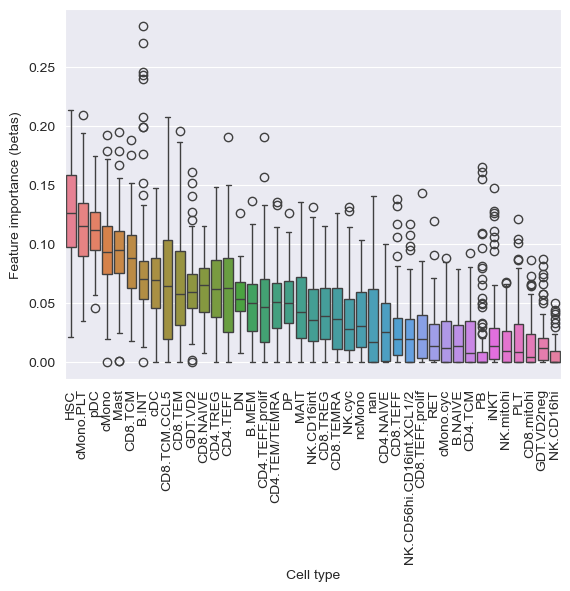

In [17]:
sort_idx = np.argsort(np.abs(feat_imp.mean(axis=0)))[::-1]

sns.boxplot(data={CELLTYPES[i]: np.abs(feat_imp[:, i]) for i in sort_idx})
plt.xticks(rotation=90)
plt.xlabel("Cell type")
plt.ylabel("Feature importance (betas)")
plt.show()

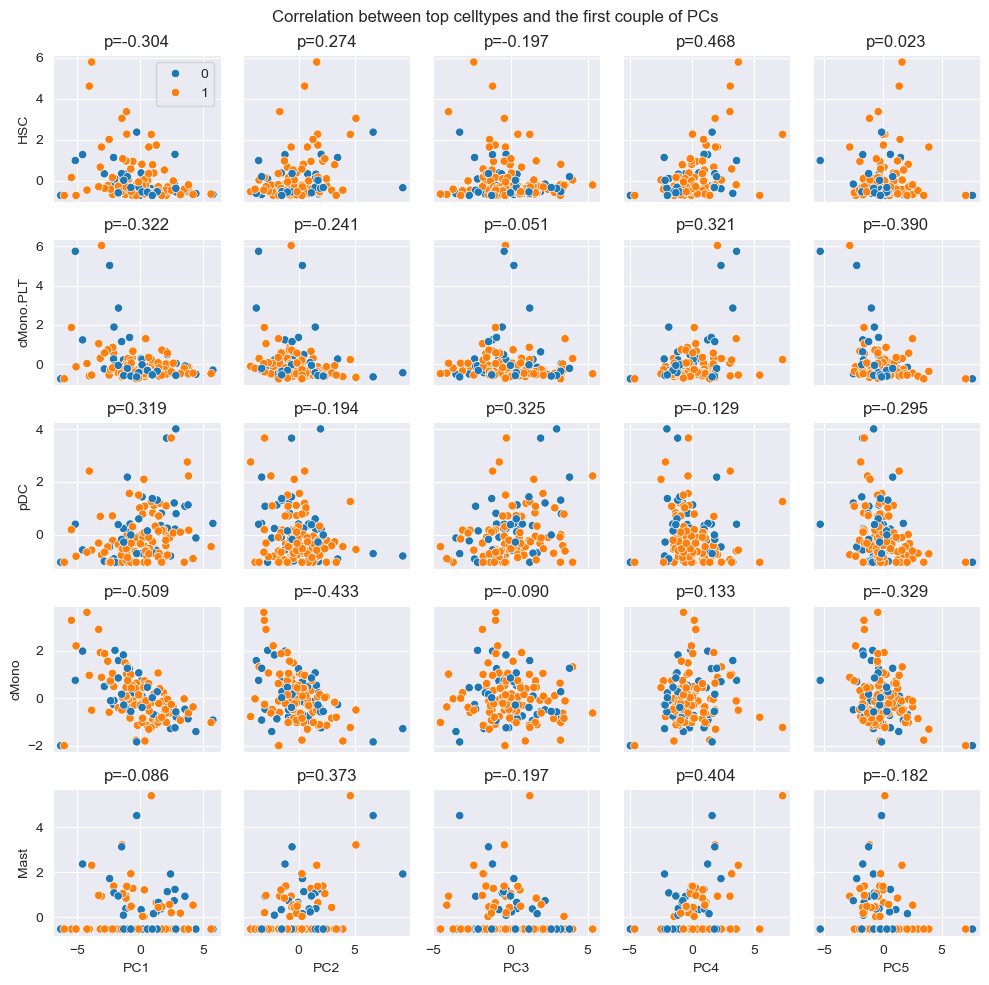

In [18]:
# Compare the correlation between the top cell types and the first couple of PCs
n_pcs = 5
n_cts = 5
fig, axs = plt.subplots(ncols=n_pcs, nrows=n_cts, figsize=(2*n_pcs, 2*n_cts), sharex="col", sharey="row")


for j in range(n_pcs):  # col
    for i in range(n_cts):  # row
        ax = axs[i, j]  # rows, cols

        ct_idx = sort_idx[i]
        ct_name = CELLTYPES[ct_idx]
        x = X_pca[:, j]
        y = X[:, ct_idx]
        
        sns.scatterplot(x=x, y=y, ax=ax, hue=cdata.obs[LABEL].values, legend=(i==0 and j==0))
        ax.set_title(f"p={np.corrcoef(x, y)[0, 1]:.3f}")
        
        # in-class correlation
        # corr_ct = np.corrcoef(x[Y == 0], y[Y == 0])[0, 1]
        # corr_ad = np.corrcoef(x[Y == 1], y[Y == 1])[0, 1]
        # ax.set_title(f"CT: {corr_ct:.3f}, AD: {corr_ad:.3f}")

        if j == 0:
            ax.set_ylabel(f"{ct_name}")
        if i == n_cts-1:
            ax.set_xlabel(f"PC{j+1}")

fig.suptitle("Correlation between top celltypes and the first couple of PCs")
plt.tight_layout()
plt.show()

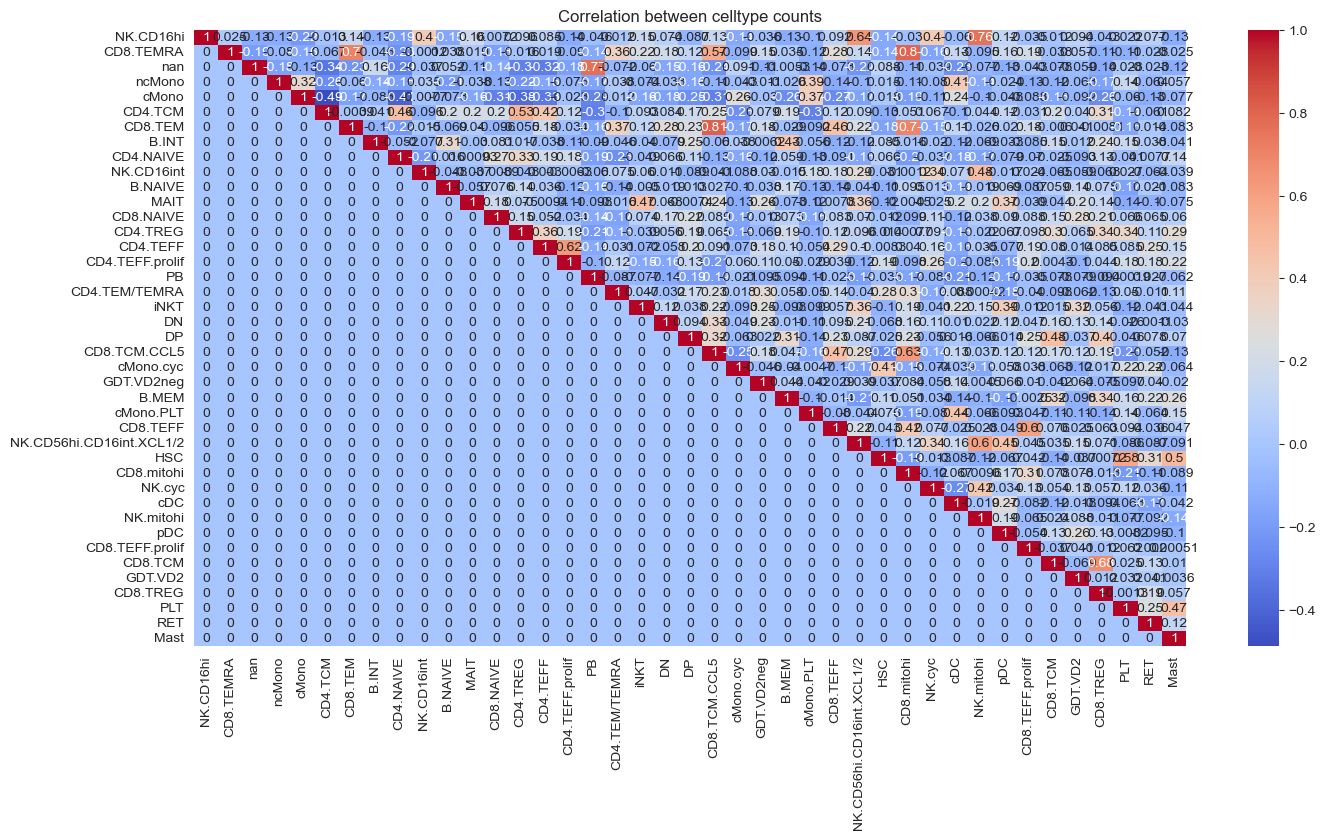

In [19]:
# compare correlations between celltype
corrs = np.zeros((len(CELLTYPES), len(CELLTYPES)))

for i, ct1 in enumerate(CELLTYPES):
    for j, ct2 in enumerate(CELLTYPES):
        if i <= j:
            corrs[i, j] = np.corrcoef(X[:, i], X[:, j])[0, 1]

plt.figure(figsize=(16, 8))
sns.heatmap(corrs, annot=True, xticklabels=CELLTYPES, yticklabels=CELLTYPES, cmap="coolwarm")
plt.title("Correlation between celltype counts")
plt.show()